In [75]:
# Scraping song lyrics from Genius and Spotify
# Spotify client ID: 2573a6dc58484146b0434289ffe03af5
# Spotify client Secret: 78ca0bfc6e77486991c3faa1d507afc2
# user_id = this will probably be a list, will test with https://open.spotify.com/user/spotify?si=3991b93174d04be3
# playlist_id = also a list, testing with https://open.spotify.com/playlist/37i9dQZF1E35BhKQRss82L
# This particular class scrapes a playlist for lyrics, will need to find a way to extrapolate this out to multiple playlists/ an entire category. May need to look at creating a list of user/playlist IDs to loop over? 
# Will use this class if I have time, building model first with Kaggle data. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

spotify_client_id = '2573a6dc58484146b0434289ffe03af5'
spotify_client_secret = '78ca0bfc6e77486991c3faa1d507afc2'
user_id = '3991b93174d04be3'
playlist_id = '37i9dQZF1E35BhKQRss82L'

#a class to scrape Genius HTML for Lyrics using Spotify artist/track information
class GetSpotifyInfo():
    
    #initializing class
    def __init__(self, spotify_client_id, spotify_client_secret, user_id, playlist_id):
        self.spotify_client_id = spotify_client_id
        self.spotify_client_secret = spotify_client_secret
        self.user_id = user_id
        self.playlist_id = playlist_id

    #function to use Spotify credentials to get playlist tracks using API credentials and user/playlist ID    
    def get_playlist_info(self):
        credentials = SpotifyClientCredentials(client_id = self.spotify_client_id, client_secret = self.spotify_client_secret)
        sp = spotipy.Spotify(client_credentials_manager=credentials)
        playlist = sp.user_playlist_tracks(self.user_id, self.playlist_id)
        self.playlist = playlist
        return self.playlist
    
    #appends track names into a list
    def get_track_names(self):
        track_names = []
        for song in range(len(self.playlist['items'])):
            track_names.append(self.playlist['items'][song]['track']['name'])
        print(*track_names)
        self.track_names = track_names
        return self.track_names
    
    #appends artist names into a list
    def get_track_artists(self):
        track_artists = []
        for song in range(len(self.playlist['items'])):
            track_artists.append(self.playlist['items'][song]['track']['artists'][0]['name'])
        self.track_artists = track_artists
        return self.track_artists

    #get track id, feed this list into audio features function to get audio features for this playlist.
    def get_track_id(self):
        track_id = []
        for song in range(len(self.playlist['items'])):
            track_id.append(self.playlist['items'][song]['track']['id'])
        self.track_id = track_id
        return self.track_id

In [72]:
#initializing song features (numeric) csv

spotify_song_features = pd.read_csv("../spotify_songs.csv")
spotify_song_features_copy = spotify_song_features[['liveness', 'tempo', 'energy', 'loudness', 'danceability']]
spotify_song_features_copy.head()

,liveness,tempo,energy,loudness,danceability
0,0.0887,97.091,0.401,-10.068,0.682
1,0.3470,135.225,0.880,-4.739,0.303
2,0.4890,111.904,0.652,-7.504,0.845
3,0.0664,118.593,0.378,-5.819,0.425
4,0.1380,130.018,0.887,-1.993,0.760


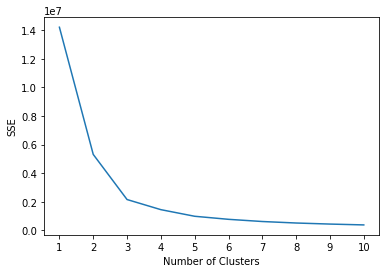

In [78]:
#elbow graph to determine ideal number of clusters for kmeans model with numerical data (unscaled data)

#kmeans parameters
kmeans_params = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each value of k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(spotify_song_features_copy)
    sse.append(kmeans.inertia_)

#visualize results in order to assess bends, which indicate best number of clusters
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#bends at 2 and 3 for indication of ideal number of clusters

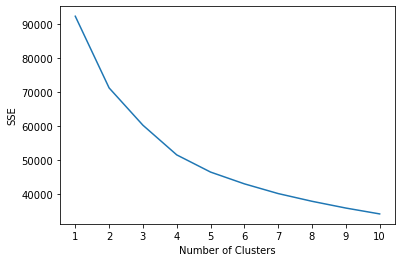

In [88]:
#trying out elbow method a second time on standard scaled data, which helps with differences in scale between characteristics of the dataset

scaled_song_features = StandardScaler().fit_transform(spotify_song_features_copy)

#create list to hold SSE values for each value of k
sse2 = []
for k in range(1, 11):
    kmeans2 = KMeans(n_clusters=k, **kmeans_params)
    kmeans2.fit(scaled_song_features)
    sse2.append(kmeans2.inertia_)

# #visualize results in order to assess bends, which indicate best number of clusters
plt.plot(range(1, 11), sse2)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#elbow graph is more subtle with standard scaler involved but bends are at 2 and 4, indicating ideal number of clusters

In [103]:
#instantiate the k-means class, using optimal number of clusters found by analyzing elbow curve above (going with 4, might try others depending on the clusters graph)
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10, random_state=1, max_iter = 300)

#fitting the model to the data, predicting clusters
labels = kmeans.fit_predict(scaled_song_features)

#adding the cluster labels to the dataframe so that I can look at attributes of the data later on
spotify_song_features_copy['kmeans_cluster'] = kmeans.labels_
spotify_song_features_copy.head()

/var/folders/zk/l8v61ht16ks5jp_8swnq6lhw0000gn/T/ipykernel_82564/1610695949.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_song_features_copy['kmeans_cluster'] = kmeans.labels_


,liveness,tempo,energy,loudness,danceability,kmeans_cluster
0,0.0887,97.091,0.401,-10.068,0.682,2
1,0.3470,135.225,0.880,-4.739,0.303,1
2,0.4890,111.904,0.652,-7.504,0.845,3
3,0.0664,118.593,0.378,-5.819,0.425,2
4,0.1380,130.018,0.887,-1.993,0.760,0


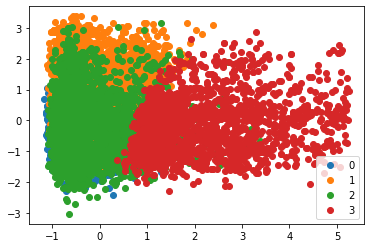

In [104]:
#get unique values for cluster labels, store in a variable for future use in plotting
unique_labels = np.unique(spotify_song_features_copy['kmeans_cluster'])

#plotting the results:
for i in unique_labels:
    plt.scatter(scaled_song_features[labels == i , 0] , scaled_song_features[labels == i, 1], label = i)
plt.legend()
plt.show()

In [106]:
spotify_song_features_copy.loc[spotify_song_features_copy['kmeans_cluster'] == 3]

,liveness,tempo,energy,loudness,danceability,kmeans_cluster
2,0.489,111.904,0.652,-7.504,0.845,3
8,0.361,130.001,0.746,-4.894,0.573,3
15,0.737,104.708,0.902,-4.826,0.521,3
18,0.460,109.945,0.771,-5.779,0.665,3
21,0.632,140.132,0.453,-9.965,0.756,3
...,...,...,...,...,...,...
18358,0.374,103.956,0.769,-6.381,0.686,3
18373,0.406,127.982,0.948,-3.922,0.656,3
18384,0.547,148.599,0.891,-4.764,0.439,3
18430,0.333,106.177,0.731,-8.299,0.588,3


In [110]:
spotify_song_features_copy.loc[spotify_song_features_copy['kmeans_cluster'] == 2]

,liveness,tempo,energy,loudness,danceability,kmeans_cluster
0,0.0887,97.091,0.401,-10.068,0.682,2
3,0.0664,118.593,0.378,-5.819,0.425,2
6,0.1450,87.261,0.594,-10.050,0.764,2
11,0.0614,78.014,0.457,-9.359,0.706,2
22,0.0674,106.035,0.570,-13.145,0.880,2
...,...,...,...,...,...,...
18425,0.1070,146.834,0.397,-8.475,0.566,2
18426,0.1200,99.700,0.391,-10.386,0.383,2
18434,0.1280,143.813,0.602,-9.351,0.708,2
18439,0.0645,118.288,0.347,-13.398,0.656,2


In [112]:
spotify_song_features_copy.loc[spotify_song_features_copy['kmeans_cluster'] == 1]

,liveness,tempo,energy,loudness,danceability,kmeans_cluster
1,0.3470,135.225,0.880,-4.739,0.303,1
5,0.0975,147.764,0.639,-6.157,0.496,1
12,0.1830,142.006,0.903,-2.955,0.725,1
19,0.1180,179.740,0.357,-7.555,0.495,1
20,0.0488,96.044,0.806,-2.892,0.414,1
...,...,...,...,...,...,...
18445,0.0807,191.985,0.745,-6.265,0.715,1
18447,0.3630,165.818,0.504,-10.003,0.425,1
18448,0.0919,154.962,0.715,-6.103,0.744,1
18449,0.3350,128.012,0.800,-5.778,0.479,1


In [111]:
spotify_song_features_copy.loc[spotify_song_features_copy['kmeans_cluster'] == 0]

,liveness,tempo,energy,loudness,danceability,kmeans_cluster
4,0.1380,130.018,0.887,-1.993,0.760,0
7,0.0513,102.459,0.860,-6.346,0.743,0
9,0.1920,120.002,0.725,-6.058,0.754,0
10,0.0620,117.009,0.882,-5.589,0.794,0
13,0.1400,111.115,0.657,-6.722,0.865,0
...,...,...,...,...,...,...
18442,0.1270,74.776,0.766,-5.513,0.667,0
18446,0.1870,107.056,0.940,-5.494,0.637,0
18450,0.2140,129.990,0.603,-6.224,0.963,0
18452,0.0720,109.536,0.666,-4.920,0.832,0


In [109]:
#initiating CSV file with english and portuguese songs for use in language recognition model

lyricscsv = pd.read_csv("../lyrics-data.csv")
lyrics_csv = lyricscsv.drop(columns=['ALink', 'SLink'])
lyricscsv.head()

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt


In [108]:
# importing fasttext to explore the pretrained model here, predicting languages and calling module
import fasttext
pretrained_model_path = "../fastText/lid.176.bin"
model = fasttext.load_model(pretrained_model_path)

In [51]:
sentence = ['Tudo o que eu quero nessa vida', 'Sweat in the heat for days on end', 'Je suis un chien']
model.predict(sentence)

([['__label__pt'], ['__label__en'], ['__label__fr']],
 [array([0.9250701], dtype=float32),
  array([0.8138323], dtype=float32),
  array([0.9999173], dtype=float32)])